# A notebook for comparing PIPS and TTU StickNets for IOP2-2022

In [1]:
import numpy as np
import numpy.ma as ma
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.ticker as ticker
import matplotlib.dates as dates
from mpl_toolkits.axes_grid1 import ImageGrid,make_axes_locatable,host_subplot
#from mpl_toolkits.basemap import Basemap
from datetime import datetime, timedelta
import sys
import os
import pyPIPS.utils as utils
import pyPIPS.thermolib as thermo
import pyPIPS.DSDlib as dsd
#import pyPIPS.disdrometer_module as dis
import pyPIPS.plotmodule as PIPSplot
#import pyPIPS.simulator as sim
import pyPIPS.pips_io as pipsio
import pyPIPS.PIPS as pips
import pyPIPS.parsivel_params as pp
import pyPIPS.parsivel_qc as pqc
import pyPIPS.polarimetric as dualpol
import pyPIPS.timemodule as ptime
# from pyCRMtools.modules import plotmodule as plotmod
from pyCRMtools.modules import utils as CRMutils
# from pyCRMtools.pycaps import arps_read
# from pyCRMtools.pycaps import pycaps_fields
# from pyCRMtools.pycaps import calvars_radar as radar
import pandas as pd
import xarray as xr
import glob
import numpy.random as random
from scipy.stats import gamma, uniform
from scipy.special import gamma as gammafunc
from scipy import ndimage
from metpy.plots import StationPlot
from metpy.calc import wind_components
from metpy.cbook import get_test_data
from metpy.plots import StationPlot
from metpy.plots.wx_symbols import current_weather, sky_cover
from metpy.units import units
import cartopy.crs as ccrs
import cartopy.feature as feature
# from natsort import natsorted
from pprint import pprint
import warnings
warnings.simplefilter('ignore')
%load_ext autoreload
%autoreload 2
%matplotlib inline


## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119



In [12]:
# print(matplotlib.style.available)

matplotlib.style.use('seaborn-v0_8-bright')

def comp_plot(PIPS_names, ds_dict, varname='fasttemp', alpha=1.0, mask_below=None, x='time'):
    fig, ax = plt.subplots(figsize=(10, 10))
    for PIPS_name in PIPS_names:
        plotvar = ds_dict[PIPS_name][varname]
        if mask_below is not None:
            plotvar = plotvar.where(plotvar > mask_below)
        plotvar.plot(ax=ax, label=PIPS_name, alpha=alpha, x=x)
    ax.legend(loc='best')
    return fig, ax

def comp_var_plot(ds, varnames=['pcount', 'pcount_derived'], alpha=1.0, mask_below=None):
    fig, ax = plt.subplots(figsize=(10, 10))
    for varname in varnames:
        plotvar = ds[varname]
        if mask_below is not None:
            plotvar = plotvar.where(plotvar > mask_below)
        plotvar.plot(ax=ax, label=varname, alpha=alpha)
    ax.legend(loc='best')
    return fig, ax

def comp_var_ds_plot(ds1, ds2, var1, var2, alpha=1.0, mask_below=None):
    fig, ax = plt.subplots(figsize=(10, 10))
    plotvar1 = ds1[var1]
    plotvar2 = ds2[var2]
    if mask_below is not None:
        plotvar1 = plotvar1.where(plotvar1 > mask_below)
        plotvar2 = plotvar2.where(plotvar2 > mask_below)
    plotvar1.plot(ax=ax, label=f'{ds1.probe_name}: {var1}', alpha=alpha)
    plotvar2.plot(ax=ax, label=f'{ds2.probe_name}: {var2}', alpha=alpha)
    ax.legend(loc='best')
    return fig, ax

# Define a formatter function to format the x-axis labels for timedeltas
def time_formatter(x, pos):
    td = pd.to_timedelta(x, unit='s')
    total_seconds = int(td.total_seconds())
    if total_seconds < 0:
        total_seconds = abs(total_seconds)
        sign = "-"
    else:
        sign = ""
    hours, remainder = divmod(total_seconds, 3600)
    minutes, seconds = divmod(remainder, 60)
    return f'{sign}{hours:02}:{minutes:02}:{seconds:02}'


def adjust_time_coordinate(ds, gust_front_time):
    # Calculate the relative time
    relative_time = ds['time'] - gust_front_time
    relative_time = relative_time.dt.total_seconds()
    
    # Assign the new coordinate
    ds = ds.assign_coords(relative_time=relative_time)
    
    # Set the new time coordinate
    ds = ds.swap_dims({'time': 'relative_time'})
    
    # Drop the old time coordinate if desired
    # ds = ds.drop_vars('time')
    
    return ds


def read_StickNet_locs_to_xarray(filepath):
    """Given the path to the StickNet locations file, read it into an xarray Dataset"""
    df = pd.read_csv(filepath)
    ds = df.to_xarray()
    ds = ds.assign_coords(ID=('index', ds['ID'].to_numpy()))
    ds = ds.swap_dims({'index': 'ID'})

    return ds

def read_StickNet_level3_to_xarray(dir, deployment_name, probe_id, loc_ds):
    """Given the directory containing the level3 files and an xarray Dataset containing the location information,
       read the data into an xarray Dataset"""
    probe_filename = f"0{probe_id}_{deployment_name}_level3.txt"
    probe_filepath = os.path.join(dir, probe_filename)
    probe_df = pd.read_csv(probe_filepath)
    # Set the time index
    probe_df['Time'] = pd.DatetimeIndex(probe_df['Time'])
    probe_df.set_index("Time", inplace=True)
    probe_ds = probe_df.to_xarray()

    # Set location, probe id, start and end times, etc., as attributes
    probe_ds.attrs['probe_name'] = probe_id
    lat = loc_ds.sel(ID=probe_id)['Latitude'].to_numpy().item()
    lon = loc_ds.sel(ID=probe_id)['Longitude'].to_numpy().item()
    elev = loc_ds.sel(ID=probe_id)['Elevation'].to_numpy().item()
    location_tuple = (lat, lon, elev)
    probe_ds.attrs['location'] = str(location_tuple)
    probe_ds.attrs['Array_Type'] = "Fine"
    starting_time = probe_ds['Time'][0].dt.strftime("%Y%m%d%H%M%S").item()
    ending_time = probe_ds['Time'][-1].dt.strftime("%Y%m%d%H%M%S").item()
    probe_ds.attrs['starting_time'] = starting_time
    probe_ds.attrs['ending_time'] = ending_time

    return probe_ds

In [41]:
# date = '052516' # '053122' # '030622' # '061416'

PIPS_dir = "/Users/dawson29/Projects/PERiLS/obsdata/2022/PIPS_data/IOP2_033022/netcdf"
deployment_name = "IOP2_033022"

PIPS_names = ['PIPS1A', 'PIPS1B', 'PIPS2A', 'PIPS3B']
parsivel_interval = 10
parsivel_filenames = ['parsivel_combined_{}_{}_{:d}s.nc'.format(deployment_name, PIPS_name, parsivel_interval)
                      for PIPS_name in PIPS_names]
parsivel_filepaths = [os.path.join(PIPS_dir, parsivel_filename) for parsivel_filename in parsivel_filenames]
conv_filenames = ['conventional_raw_{}_{}.nc'.format(deployment_name, PIPS_name) for PIPS_name in PIPS_names]
conv_filepaths = [os.path.join(PIPS_dir, conv_filename) for conv_filename in conv_filenames]
parsivel_ds_read_dict = {}
conv_ds_read_dict = {}
for PIPS_name, parsivel_filepath, conv_filepath in zip(PIPS_names, parsivel_filepaths, conv_filepaths):
    parsivel_ds_read_dict[PIPS_name] = xr.load_dataset(parsivel_filepath)
    conv_ds_read_dict[PIPS_name] = xr.load_dataset(conv_filepath)

In [42]:
for PIPS_name in PIPS_names:
    parsivel_ds = parsivel_ds_read_dict[PIPS_name]
    print(parsivel_ds['time'][0], parsivel_ds['time'][-1])

<xarray.DataArray 'time' ()> Size: 8B
array('2022-03-30T23:49:43.000000000', dtype='datetime64[ns]')
Coordinates:
    time           datetime64[ns] 8B 2022-03-30T23:49:43
    flagged_times  int64 8B 0 <xarray.DataArray 'time' ()> Size: 8B
array('2022-03-31T01:25:23.000000000', dtype='datetime64[ns]')
Coordinates:
    time           datetime64[ns] 8B 2022-03-31T01:25:23
    flagged_times  int64 8B 0
<xarray.DataArray 'time' ()> Size: 8B
array('2022-03-30T23:41:53.000000000', dtype='datetime64[ns]')
Coordinates:
    time           datetime64[ns] 8B 2022-03-30T23:41:53
    flagged_times  int64 8B 0 <xarray.DataArray 'time' ()> Size: 8B
array('2022-03-31T01:33:03.000000000', dtype='datetime64[ns]')
Coordinates:
    time           datetime64[ns] 8B 2022-03-31T01:33:03
    flagged_times  int64 8B 0
<xarray.DataArray 'time' ()> Size: 8B
array('2022-03-30T23:59:03.000000000', dtype='datetime64[ns]')
Coordinates:
    time           datetime64[ns] 8B 2022-03-30T23:59:03
    flagged_times  int64 

In [43]:
# Restrict to certain time range
# start_time = '2022-05-31T23:00' # '2022-03-07T00:00'
# end_time = '2022-06-01T00:05' # '2022-03-08T00:00'
# start_time = '2022-03-30T23:40'
# end_time = '2022-03-31T01:30'
# start_time = '2023-03-12T00:15'
# end_time = '2023-03-12T14:00'
# start_time = '2023-02-22T16:00'
# end_time = '2023-02-23T01:00'
start_time = '2023-03-16T17:45'
end_time = '2023-03-17T15:05'

if False:
    parsivel_ds_dict = {}
    conv_ds_dict = {}
    for PIPS_name in PIPS_names:
        parsivel_ds_dict[PIPS_name] = parsivel_ds_read_dict[PIPS_name].sel(time=slice(start_time, end_time))
        conv_ds_dict[PIPS_name] = conv_ds_read_dict[PIPS_name].sel(time=slice(start_time, end_time))
else:
    parsivel_ds_dict = parsivel_ds_read_dict
    conv_ds_dict = conv_ds_read_dict

In [4]:
# Read in StickNet data (level 3)

stick_dir = "/Users/dawson29/Projects/PERiLS/obsdata/2022/TTU_StickNet"
IOP_name = "IOP2"

location_file = f"{IOP_name}_StickNet_Locations.csv"
location_path = os.path.join(stick_dir, location_file)

sticknet_locs_ds = read_StickNet_locs_to_xarray(location_path)
sticknet_fine_locs_ds = sticknet_locs_ds.where(sticknet_locs_ds['Array_Type'] == 'Fine', drop=True)

In [5]:
sticknet_fine_locs_ds

<xarray.Dataset> Size: 384B
Dimensions:     (ID: 8)
Coordinates:
    index       (ID) int64 64B 2 3 9 10 12 13 19 20
  * ID          (ID) object 64B '103A' '104A' '110A' ... '214A' '220A' '221A'
Data variables:
    Latitude    (ID) float64 64B 33.71 33.82 33.76 33.79 33.77 33.8 33.73 33.74
    Longitude   (ID) float64 64B -88.45 -88.46 -88.45 ... -88.46 -88.44 -88.44
    Elevation   (ID) float64 64B 72.4 73.8 76.8 68.9 71.4 70.4 87.2 81.8
    Array_Type  (ID) object 64B 'Fine' 'Fine' 'Fine' ... 'Fine' 'Fine' 'Fine'

In [6]:
sticknet_fine_ids = sticknet_fine_locs_ds['ID'].to_numpy()

sticknet_ds_list = [read_StickNet_level3_to_xarray(stick_dir, IOP_name, probe_id, sticknet_fine_locs_ds) for probe_id in sticknet_fine_ids]
sticknet_ds_dict = {stick_id: stick_ds for stick_id, stick_ds in zip(sticknet_fine_ids, sticknet_ds_list)}

In [10]:
sticknet_ds_dict['103A']

<xarray.Dataset> Size: 355kB
Dimensions:  (Time: 7402)
Coordinates:
  * Time     (Time) datetime64[ns] 59kB 2022-03-30T23:43:00 ... 2022-03-31T01...
Data variables:
    T        (Time) float64 59kB 21.8 21.8 21.9 21.9 ... 17.2 17.2 17.2 17.2
    RH       (Time) float64 59kB 81.3 81.4 81.5 81.5 ... 93.0 93.0 93.0 93.0
    P        (Time) float64 59kB 991.9 992.0 992.0 991.9 ... 993.5 993.5 993.5
    WS       (Time) float64 59kB 5.8 5.4 5.2 5.2 6.6 6.2 ... 3.2 3.2 3.2 3.2 3.2
    WD       (Time) float64 59kB 173.3 169.5 174.2 202.0 ... 179.5 167.6 180.0
Attributes:
    probe_name:     103A
    location:       (33.714987, -88.450477, 72.4)
    Array_Type:     Fine
    starting_time:  20220330234300
    ending_time:    20220331014621

In [11]:
conv_ds_dict['PIPS1A']

<xarray.Dataset> Size: 1MB
Dimensions:      (time: 5769)
Coordinates:
  * time         (time) datetime64[ns] 46kB 2022-03-30T23:49:25 ... 2022-03-3...
Data variables: (12/24)
    voltage      (time) float64 46kB 12.7 12.7 12.66 12.66 ... 12.53 12.53 12.53
    winddirrel   (time) float64 46kB nan 197.0 172.0 182.0 ... 220.0 217.0 219.0
    windspd      (time) float64 46kB nan 2.07 1.37 2.68 ... 1.77 1.65 1.41 1.72
    winddiag     (time) float64 46kB nan 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    fasttemp     (time) float64 46kB 21.11 21.09 21.06 ... 16.89 16.88 16.88
    slowtemp     (time) float64 46kB 22.16 22.07 22.18 ... 16.84 16.76 16.86
    ...           ...
    winddirabs   (time) float64 46kB nan 166.3 141.5 151.5 ... 189.8 186.8 188.8
    dewpoint     (time) float64 46kB 18.61 18.54 18.67 ... 16.21 16.13 16.25
    RH_derived   (time) float64 46kB 85.62 85.37 86.21 ... 95.8 95.37 96.08
    pt           (time) float64 46kB nan 295.0 294.9 294.9 ... 290.5 290.5 290.5
    qv           (time) float64 46kB nan 0.01374 0.01385 ... 0.01173 0.01182
    rho          (time) float64 46kB nan 1.164 1.164 1.165 ... 1.186 1.186 1.186
Attributes:
    probe_name:       PIPS1A
    parsivel_angle:   -45.0
    deployment_name:  IOP2_033022
    location:         (33.75801086325083, -88.44616666666666, 70.7434820494946)
    starting_time:    20220330234943
    ending_time:      20220331012523

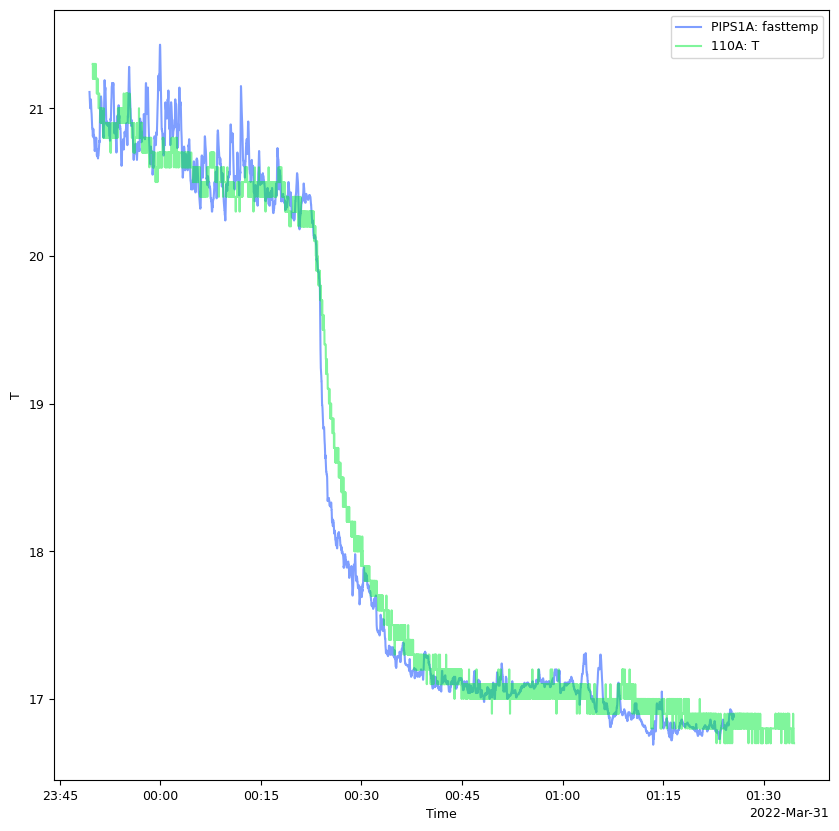

In [15]:
# Plot temperature for PIPS1A and 110A (collocated)
fig, ax = comp_var_ds_plot(conv_ds_dict['PIPS1A'], sticknet_ds_dict['110A'], 'fasttemp', 'T', alpha=0.5)

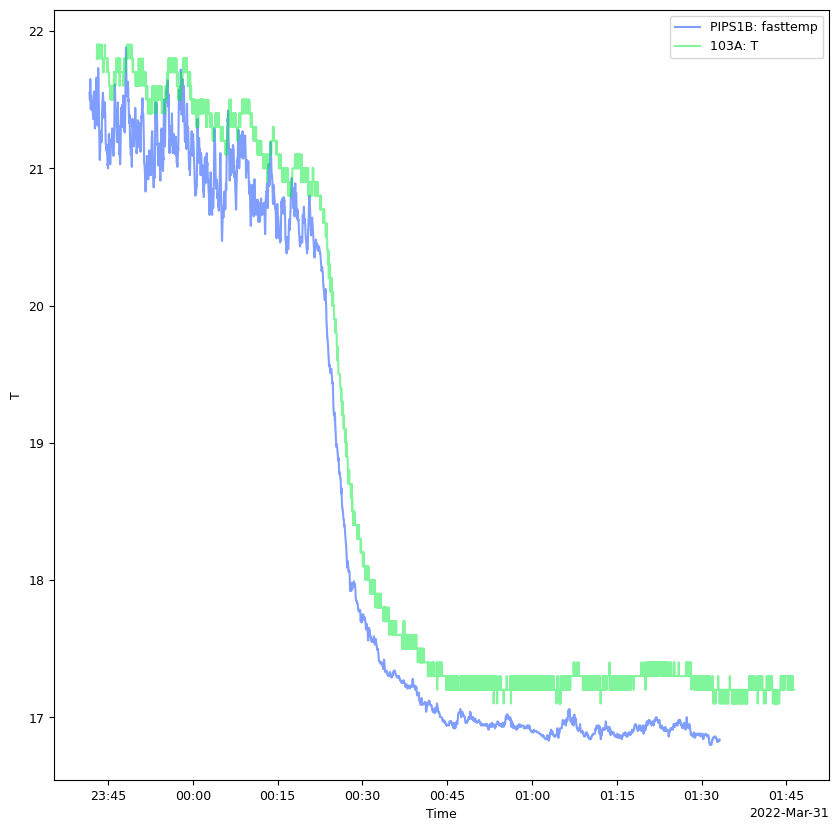

In [22]:
# Plot temperature for PIPS1B and 103A (collocated)
fig, ax = comp_var_ds_plot(conv_ds_dict['PIPS1B'], sticknet_ds_dict['103A'], 'fasttemp', 'T', alpha=0.5)

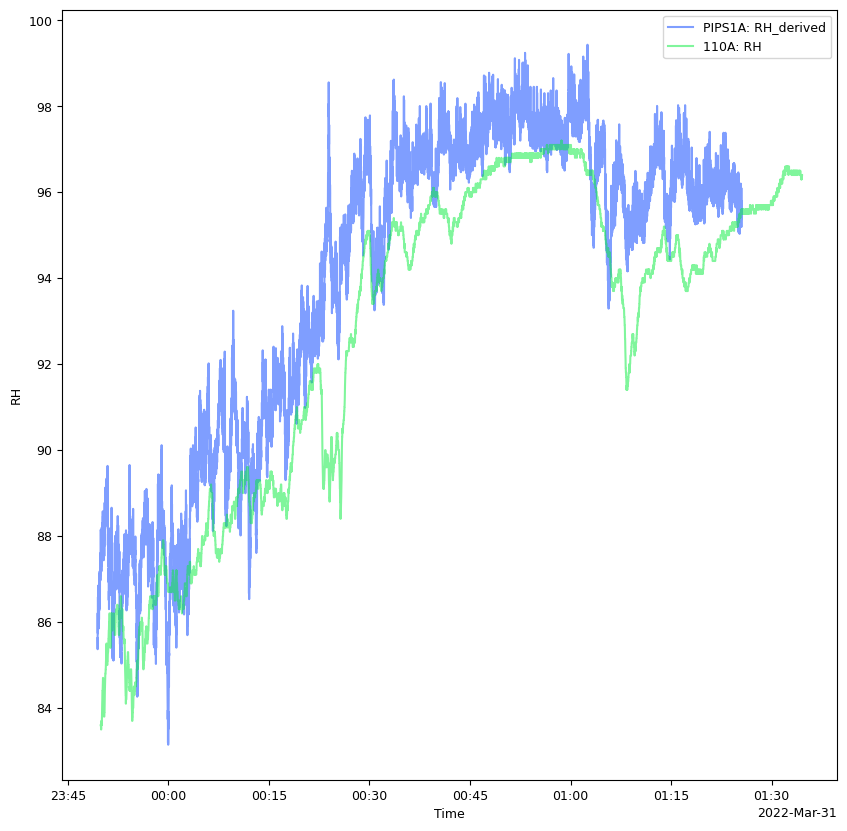

In [18]:
# Plot RH for PIPS1A and 110A (collocated)
fig, ax = comp_var_ds_plot(conv_ds_dict['PIPS1A'], sticknet_ds_dict['110A'], 'RH_derived', 'RH', alpha=0.5)

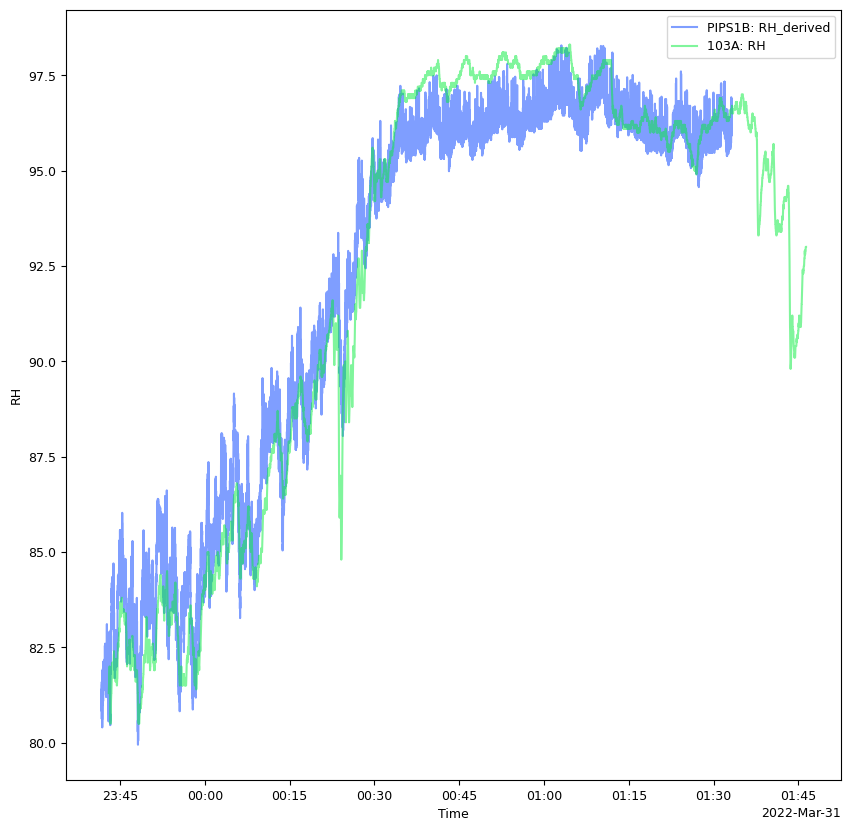

In [23]:
# Plot RH for PIPS1B and 103A (collocated)
fig, ax = comp_var_ds_plot(conv_ds_dict['PIPS1B'], sticknet_ds_dict['103A'], 'RH_derived', 'RH', alpha=0.5)

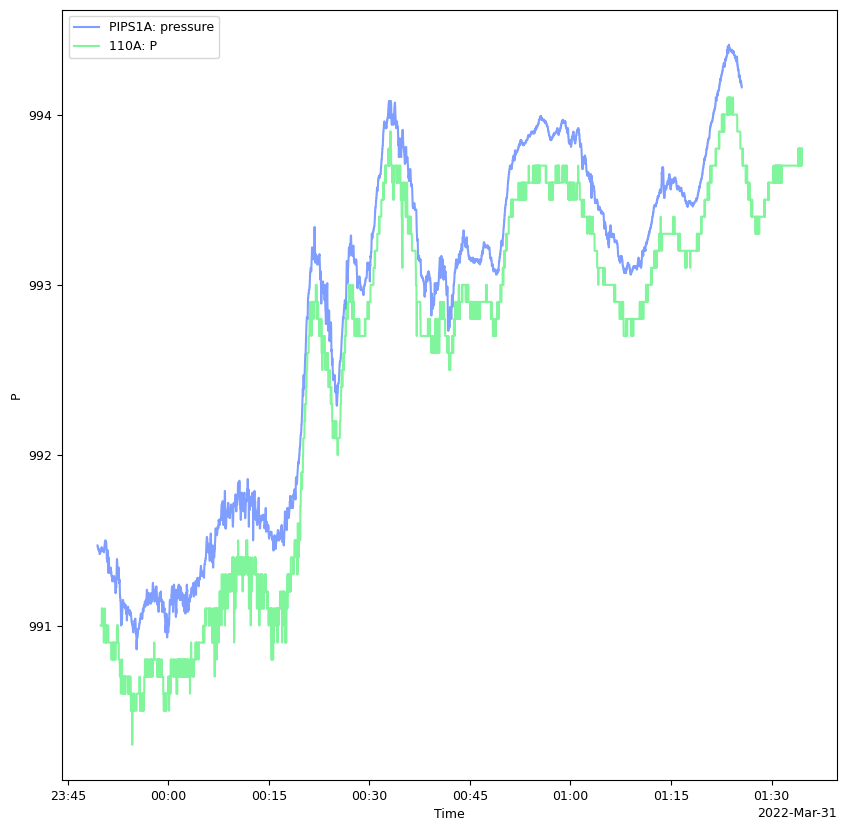

In [19]:
# Plot pressure for PIPS1A and 110A (collocated)
fig, ax = comp_var_ds_plot(conv_ds_dict['PIPS1A'], sticknet_ds_dict['110A'], 'pressure', 'P', alpha=0.5)

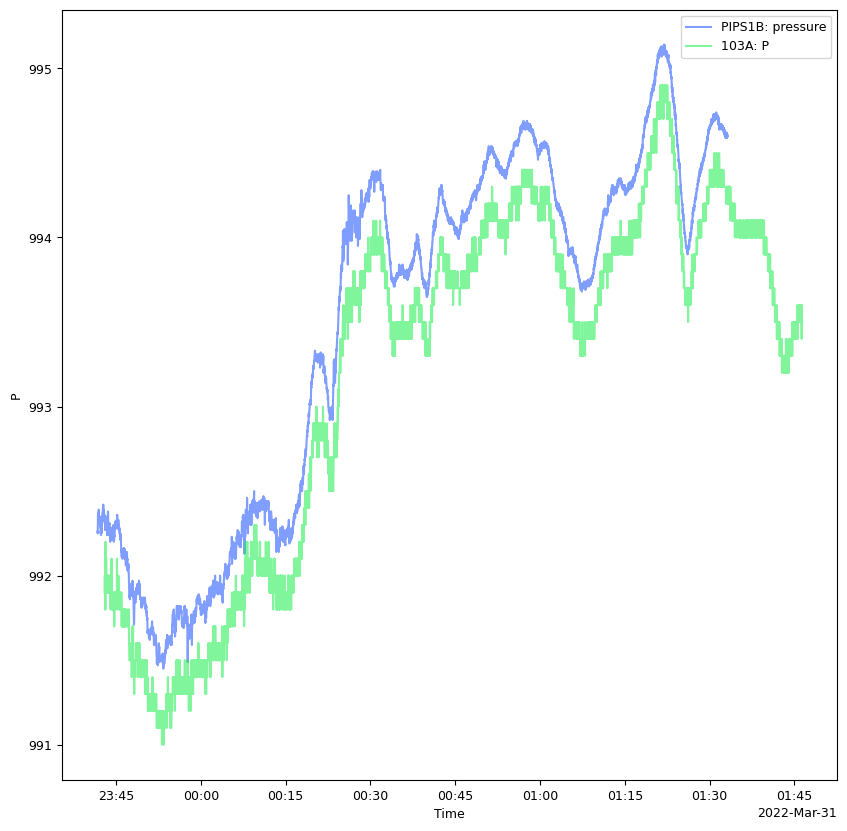

In [24]:
# Plot pressure for PIPS1B and 103A (collocated)
fig, ax = comp_var_ds_plot(conv_ds_dict['PIPS1B'], sticknet_ds_dict['103A'], 'pressure', 'P', alpha=0.5)

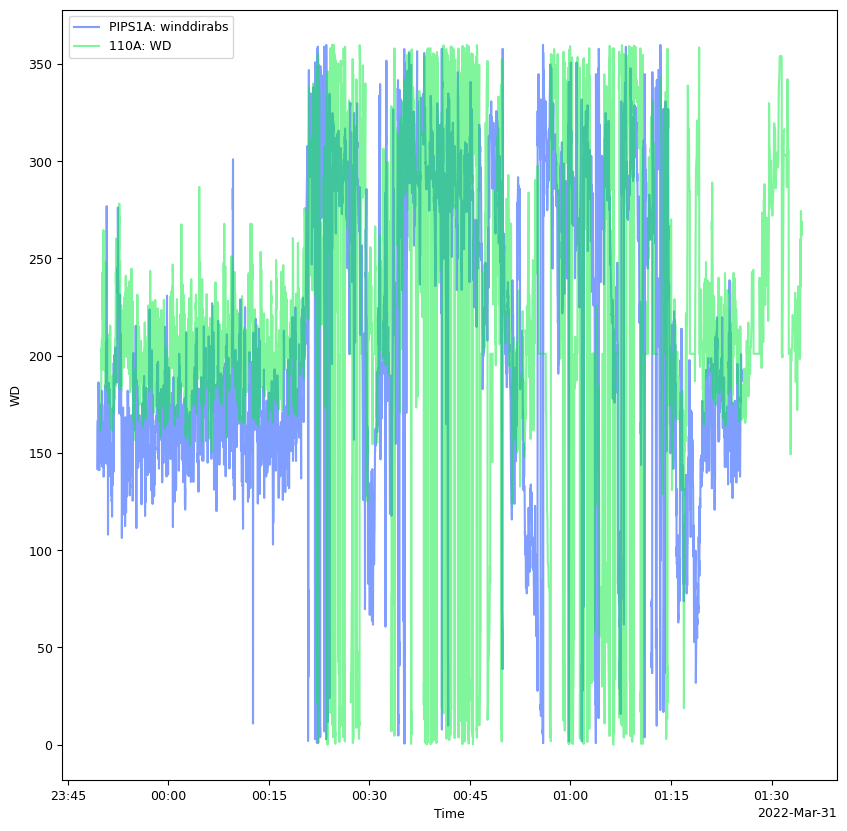

In [20]:
# Plot wind direction for PIPS1A and 110A (collocated)
fig, ax = comp_var_ds_plot(conv_ds_dict['PIPS1A'], sticknet_ds_dict['110A'], 'winddirabs', 'WD', alpha=0.5)

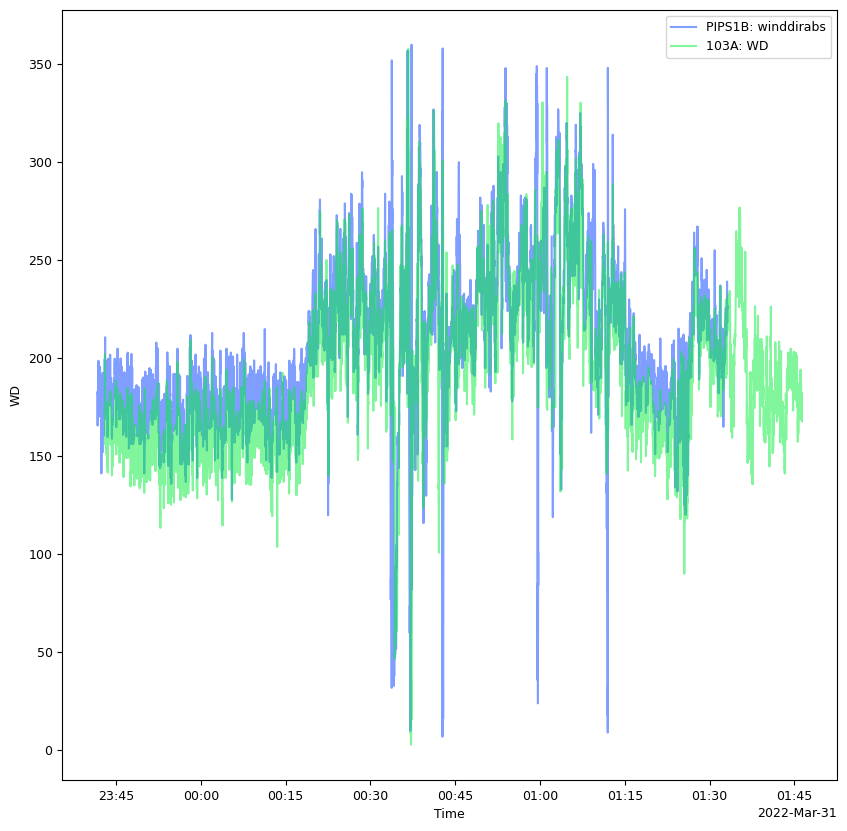

In [25]:
# Plot wind direction for PIPS1B and 103A (collocated)
fig, ax = comp_var_ds_plot(conv_ds_dict['PIPS1B'], sticknet_ds_dict['103A'], 'winddirabs', 'WD', alpha=0.5)

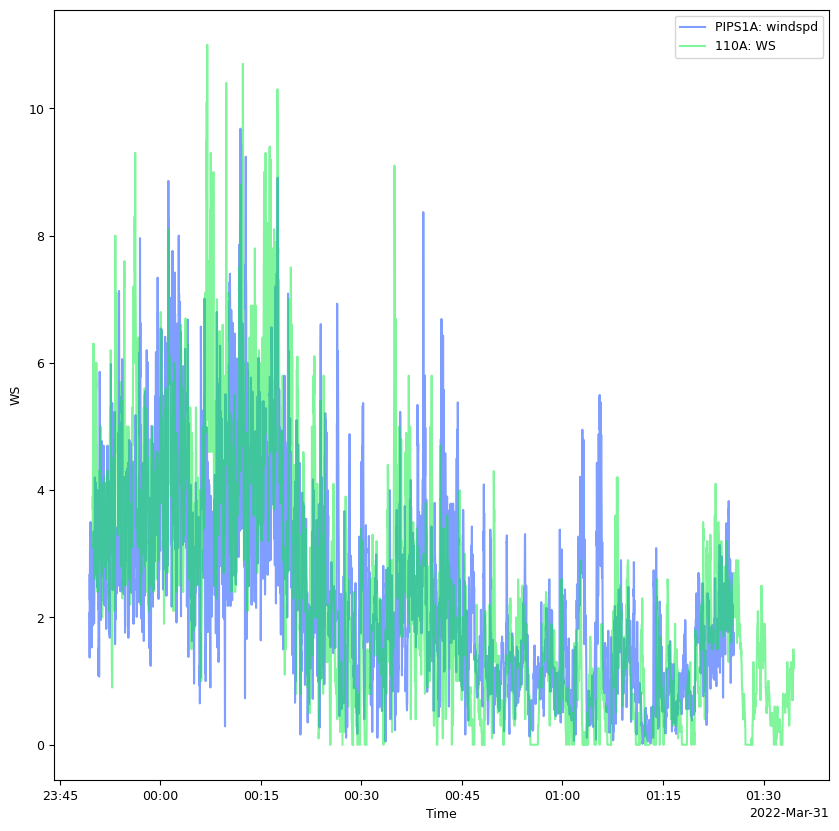

In [21]:
# Plot wind speed for PIPS1A and 110A (collocated)
fig, ax = comp_var_ds_plot(conv_ds_dict['PIPS1A'], sticknet_ds_dict['110A'], 'windspd', 'WS', alpha=0.5)

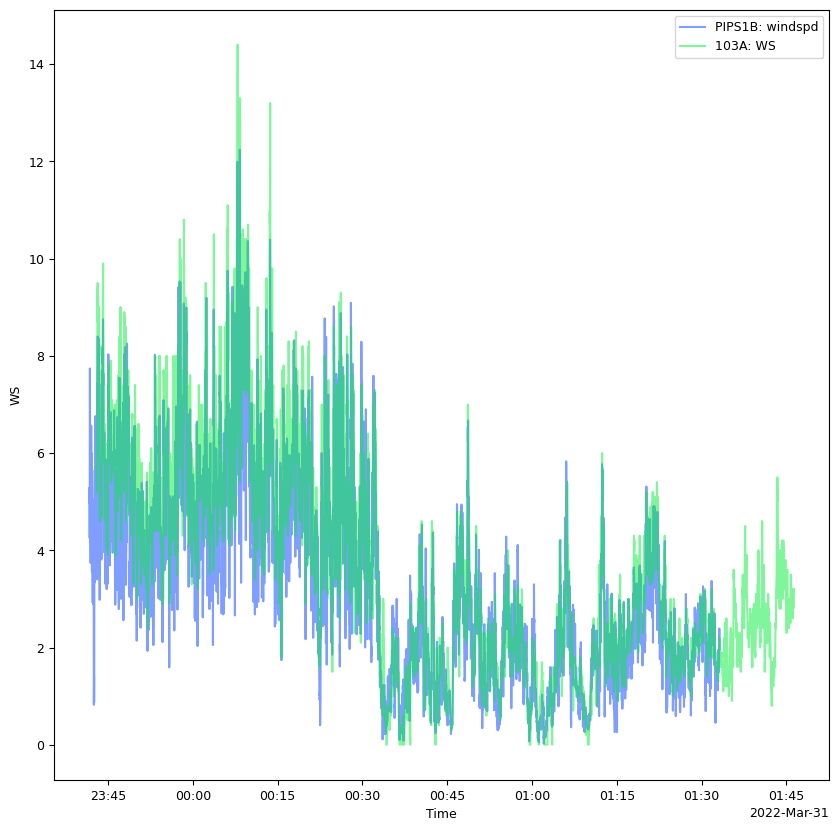

In [26]:
# Plot wind speed for PIPS1B and 103A (collocated)
fig, ax = comp_var_ds_plot(conv_ds_dict['PIPS1B'], sticknet_ds_dict['103A'], 'windspd', 'WS', alpha=0.5)

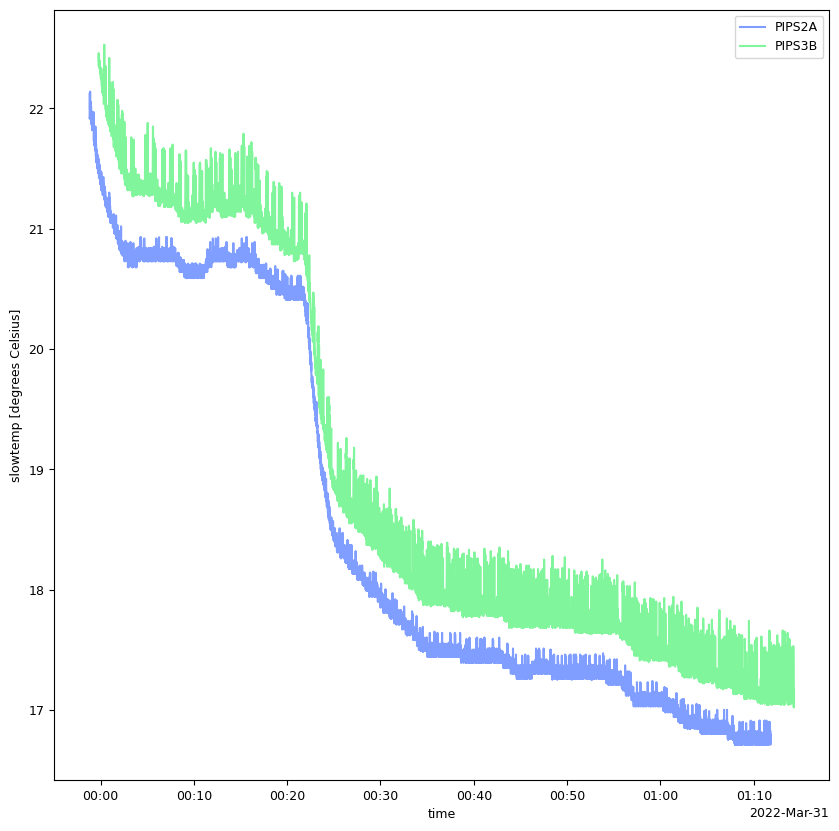

In [44]:
# Plot temperature for PIPS2A and PIPS3B (collocated)
fig, ax = comp_plot(['PIPS2A', 'PIPS3B'], conv_ds_dict, 'slowtemp', alpha=0.5)

In [73]:
# Test application of a Blackman Harris filter
import scipy.signal as signal

fs = 1  # Sampling frequency in Hz

# Design the 28th order Blackman-Harris filter
order = 28
cutoff_frequency = 0.1  # Cutoff frequency in Hz

# Normalize the cutoff frequency with respect to Nyquist frequency
normalized_cutoff = cutoff_frequency / (0.5 * fs)

# Design the filter using firwin with a Blackman-Harris window
b = signal.firwin(order + 1, normalized_cutoff, window='blackmanharris', pass_zero=True)

# Apply the filter to the temperature and relative humidity data

for name in PIPS_names:
    temperature = conv_ds_dict[name]['slowtemp']
    RH = conv_ds_dict[name]['RH_derived']
    slowtemp_filt = signal.filtfilt(b, 1, temperature)
    RH_filt = signal.filtfilt(b, 1, RH)

    conv_ds_dict[name]['slowtemp_filt'] = temperature.copy()
    conv_ds_dict[name]['slowtemp_filt'].data = slowtemp_filt
    conv_ds_dict[name]['RH_filt'] = temperature.copy()
    conv_ds_dict[name]['RH_filt'].data = RH_filt
    
    # conv_ds_dict[name]['slowtemp_filt'] = signal.lfilter(b, 1, temperature)
    # conv_ds_dict[name]['RH_derived_filt'] = signal.lfilter(b, 1, RH)

In [74]:
conv_ds_dict['PIPS2A']

<xarray.Dataset> Size: 1MB
Dimensions:        (time: 4380)
Coordinates:
  * time           (time) datetime64[ns] 35kB 2022-03-30T23:58:49 ... 2022-03...
Data variables: (12/26)
    voltage        (time) float64 35kB 12.77 12.77 12.72 ... 12.59 12.59 12.59
    winddirrel     (time) float64 35kB nan 1.0 339.0 350.0 ... 98.0 56.0 32.0
    windspd        (time) float64 35kB nan 2.07 1.98 1.97 ... 0.48 0.44 0.54
    winddiag       (time) float64 35kB nan 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    fasttemp       (time) float64 35kB 21.2 21.19 21.17 ... 16.88 16.87 16.85
    slowtemp       (time) float64 35kB 21.92 21.95 22.13 ... 16.8 16.71 16.82
    ...             ...
    RH_derived     (time) float64 35kB 83.33 83.81 84.94 ... 94.92 94.34 95.22
    pt             (time) float64 35kB nan 295.2 295.1 ... 290.6 290.6 290.6
    qv             (time) float64 35kB nan 0.01358 0.01375 ... 0.01161 0.01171
    rho            (time) float64 35kB nan 1.163 1.163 ... 1.184 1.184 1.184
    slowtemp_filt  (time) float64 35kB 21.92 21.96 21.99 ... 16.8 16.81 16.82
    RH_filt        (time) float64 35kB 83.33 83.75 84.13 ... 94.98 95.09 95.22
Attributes:
    probe_name:       PIPS2A
    parsivel_angle:   -45.0
    deployment_name:  IOP2_033022
    location:         (33.82966666666666, -88.45933333333333, 73.6733731892389)
    starting_time:    20220330235903
    ending_time:      20220331011143

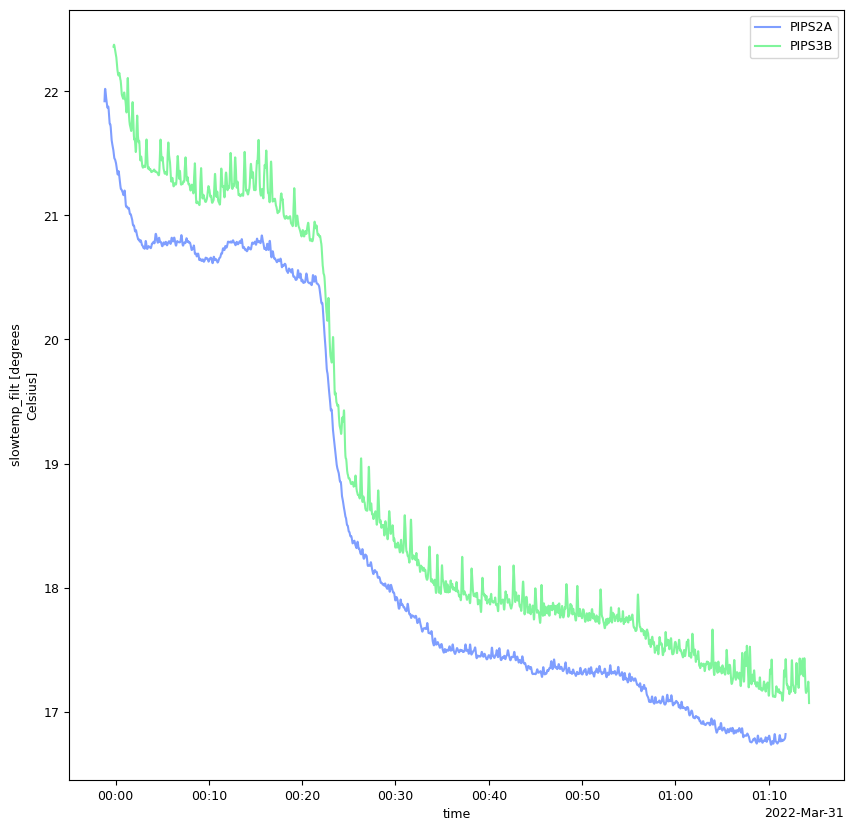

In [75]:
# Plot temperature for PIPS2A and PIPS3B (collocated)
fig, ax = comp_plot(['PIPS2A', 'PIPS3B'], conv_ds_dict, 'slowtemp_filt', alpha=0.5)

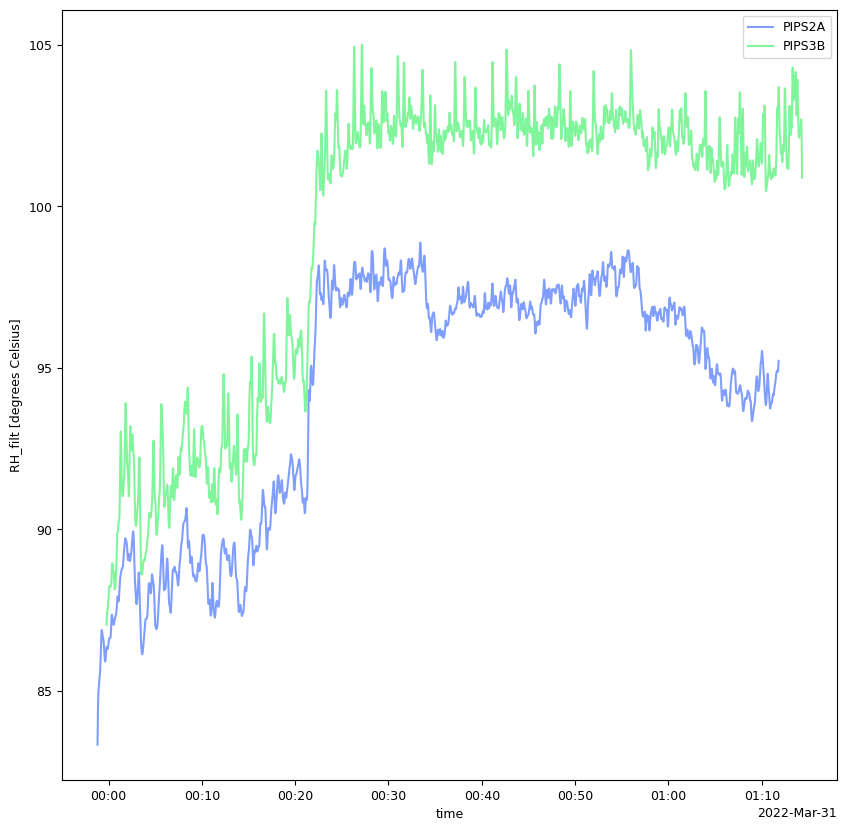

In [76]:
# Plot RH for PIPS2A and PIPS3B (collocated)
fig, ax = comp_plot(['PIPS2A', 'PIPS3B'], conv_ds_dict, 'RH_filt', alpha=0.5)

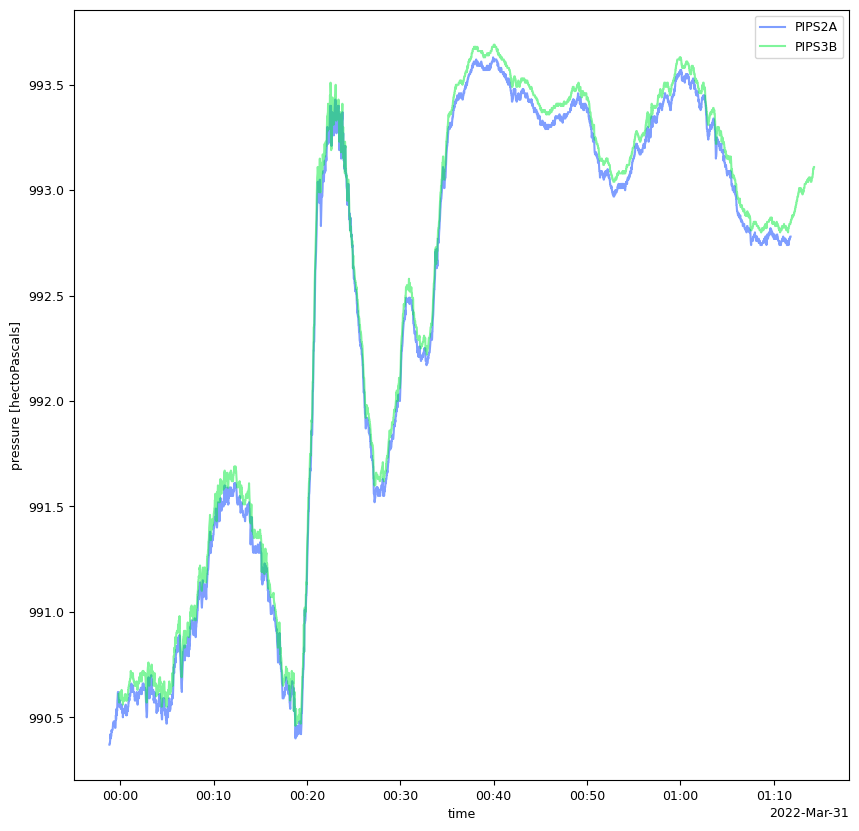

In [30]:
# Plot pressure for PIPS2A and PIPS3B (collocated)
fig, ax = comp_plot(['PIPS2A', 'PIPS3B'], conv_ds_dict, 'pressure', alpha=0.5)

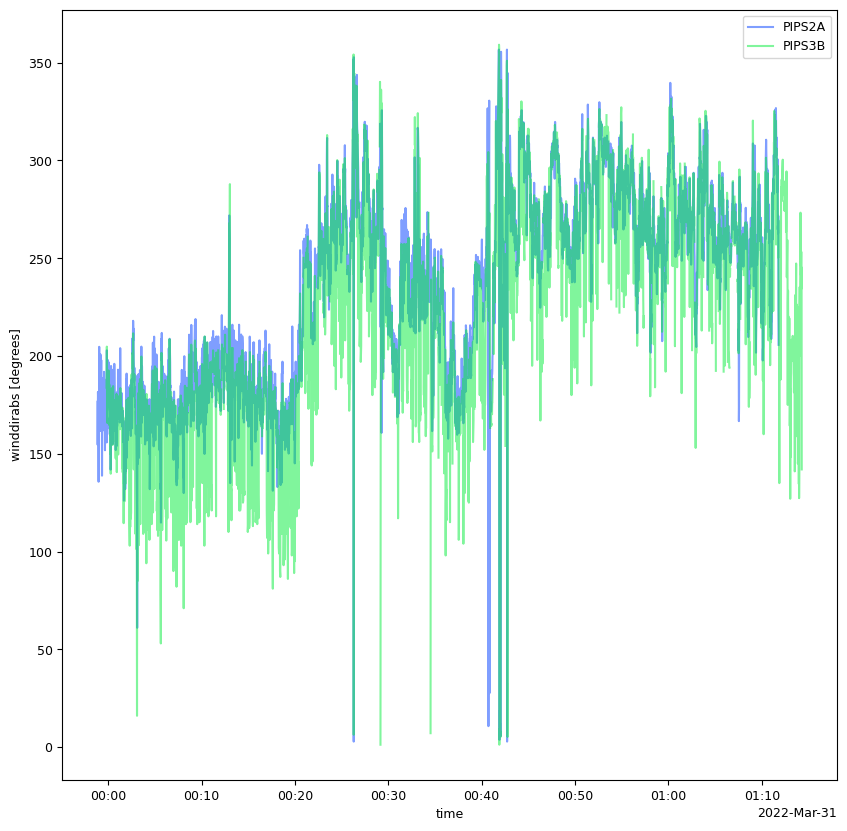

In [31]:
# Plot wind direction for PIPS2A and PIPS3B (collocated)
fig, ax = comp_plot(['PIPS2A', 'PIPS3B'], conv_ds_dict, 'winddirabs', alpha=0.5)

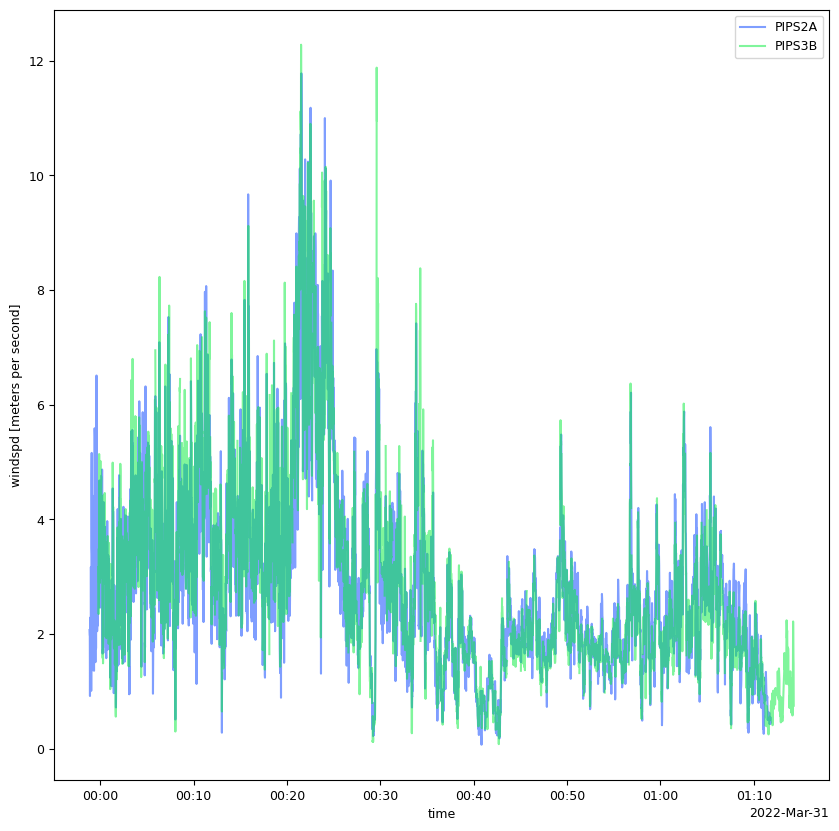

In [32]:
# Plot wind speed for PIPS2A and PIPS3B (collocated)
fig, ax = comp_plot(['PIPS2A', 'PIPS3B'], conv_ds_dict, 'windspd', alpha=0.5)

### In the following cells we will be doing the following:
1. Filter the noisy slowtemp and RH data for the PIPS (using same procedure as was done for the Sticknets)
2. Compute the gust front passage times for the Sticknet probes
3. Compute the gust front passage times for the PIPS (1-s data)
4. Re-align the data to the gust front passage times
5. Use the closest Sticknet station to each of the PIPS to calculate biases in the various conventional data using the gust-front-relative data
6. Correct the PIPS data using the biases computed in step 5

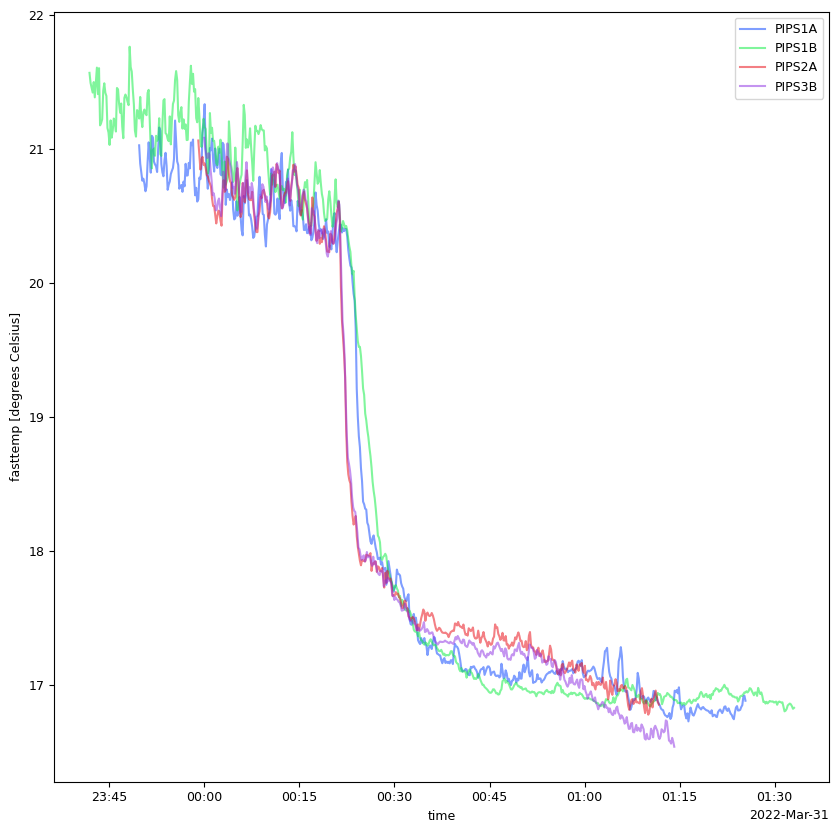

In [78]:
# Plot temperatures
fig, ax = comp_plot(PIPS_names, parsivel_ds_dict, 'fasttemp', alpha=0.5)

In [ ]:
fig, ax = comp_plot(sticknet_fine_ids, sticknet_ds_dict, 'T', alpha=0.5, x='Time')

In [ ]:
# Smooth the data a bit to remove short-range fluctuations
window_size = 12 # Corresponds to 2 min for the 10-s data
min_periods = 1

for PIPS_name in PIPS_names:
    parsivel_ds = parsivel_ds_dict[PIPS_name]
    smooth_fasttemp = parsivel_ds['fasttemp'].rolling(time=window_size, center=True, min_periods=min_periods).mean()
    parsivel_ds['smooth_fasttemp'] = smooth_fasttemp

In [ ]:
fig, ax = comp_plot(PIPS_names, parsivel_ds_dict, 'smooth_fasttemp', alpha=0.5)

In [ ]:
# Take the 1st-order difference of the smoothed temperature field
for PIPS_name in PIPS_names:
    parsivel_ds = parsivel_ds_dict[PIPS_name]
    diff_T = parsivel_ds['smooth_fasttemp'].diff(dim='time', label='upper')
    # diff_T = diff_T.where(diff_T < -0.03, drop=True)
    parsivel_ds['diff_fasttemp'] = diff_T
    



In [ ]:
# Plot the temperature difference in adjacent times
fig, ax = comp_plot(PIPS_names, parsivel_ds_dict, 'diff_fasttemp', alpha=0.5)

In [ ]:
# From the above plot, we see we can take the time of the *minimum* signed temp difference (the time where the temp is dropping the fastest)
# as the reference time for the along line average
# EDIT: It looks like a better criterion is for when the temperature drop rate first exceeds -0.06 deg C per 10 s (for the smoothed data)
temp_drop_threshold = -0.06

gust_front_times = {}
for PIPS_name in PIPS_names:
    # tindex = parsivel_ds_dict[PIPS_name]['diff_fasttemp'].argmin()
    diff_T = parsivel_ds_dict[PIPS_name]['diff_fasttemp']
    tindex = xr.where(diff_T < temp_drop_threshold, True, False).argmax(dim='time').item()
    gust_front_time = parsivel_ds_dict[PIPS_name]['time'].isel(time=tindex).values
    gust_front_times[PIPS_name] = gust_front_time
    print(gust_front_time)

In [ ]:
# Create new time coordinate as time since gust front passage
new_parsivel_ds_dict = {}
for PIPS_name, parsivel_ds in parsivel_ds_dict.items():
    gust_front_time = gust_front_times[PIPS_name]
    new_parsivel_ds_dict[PIPS_name] = adjust_time_coordinate(parsivel_ds, gust_front_time)

In [ ]:
fig, ax = comp_plot(PIPS_names, new_parsivel_ds_dict, 'fasttemp', alpha=0.5, x='relative_time')

In [ ]:
# Align datasets to common times
aligned_datasets = xr.align(*new_parsivel_ds_dict.values(), join='inner')

# Combine datasets into a new Dataset with a new dimension 'PIPS'
combined_parsivel_ds = xr.concat(aligned_datasets, dim='PIPS')
combined_parsivel_ds['PIPS'] = list(parsivel_ds_dict.keys())

# Convert TimeDelta objects to seconds for plotting
# combined_parsivel_ds = combined_parsivel_ds.assign_coords(
#     seconds_since_gust_front=combined_parsivel_ds['relative_time'].dt.total_seconds()
# )


In [ ]:
# Figure out how to average winds. We can just take the direct average of the wind speeds, gust speeds, and u and v components
# The rest we re-compute from the averaged u and v components
var_da_dict = {}
for var in ['windspd', 'windgust', 'uavg', 'vavg']:
    var_da_dict[var] = combined_parsivel_ds[var].mean(dim='PIPS', skipna=True)

# Compute vector average wind speed
var_da_dict['windspdavgvec'] = np.sqrt(var_da_dict['uavg']**2. + var_da_dict['vavg']**2.)
# Compute vector average wind direction
var_da_dict['winddirabs'] = (270.0 - (180. / np.pi) * np.arctan2(var_da_dict['vavg'], var_da_dict['uavg'])) % 360.

# Compute unit average wind speed/direction
unit_u = combined_parsivel_ds['uavg'] / combined_parsivel_ds['windspd']
unit_v = combined_parsivel_ds['vavg'] / combined_parsivel_ds['windspd']
unit_u_avg = unit_u.mean(dim='PIPS', skipna=True)
unit_v_avg = unit_v.mean(dim='PIPS', skipna=True)

wind_dir_unit_vec_avg = (270.0 - (180. / np.pi) * np.arctan2(unit_v_avg, unit_u_avg)) % 360.
wind_dir_unit_vec_avg = xr.where((unit_u_avg == 0.) & (unit_v_avg == 0.), np.nan, wind_dir_unit_vec_avg)

var_da_dict['unit_uavg'] = unit_u_avg
var_da_dict['unit_vavg'] = unit_v_avg
var_da_dict['winddirunitavgvec'] = wind_dir_unit_vec_avg


In [ ]:
var = 'winddirunitavgvec'

fig, ax = plt.subplots(figsize=(10, 8))
var_da_dict[var].plot(ax=ax, label='avg')
combined_parsivel_ds.sel(PIPS='PIPS1A')[var].plot(ax=ax, label='PIPS1A')
combined_parsivel_ds.sel(PIPS='PIPS1B')[var].plot(ax=ax, label='PIPS1B')
combined_parsivel_ds.sel(PIPS='PIPS2A')[var].plot(ax=ax, label='PIPS2A')
combined_parsivel_ds.sel(PIPS='PIPS3B')[var].plot(ax=ax, label='PIPS3B')
ax.legend(loc='best')

In [ ]:
# Sanity check

spd = np.sqrt(var_da_dict['unit_uavg']**2. + var_da_dict['unit_vavg']**2.)
spd.plot()

In [ ]:
spd = np.sqrt(combined_parsivel_ds.sel(PIPS='PIPS1A')['unit_uavg']**2. + combined_parsivel_ds.sel(PIPS='PIPS1A')['unit_vavg']**2.)
spd.plot()

In [ ]:

# Compute the average across the 'PIPS' dimension
parsivel_average_ds = combined_parsivel_ds.mean(dim='PIPS')


In [ ]:
combined_parsivel_ds

In [ ]:
new_new_parsivel_dict = {}
for PIPS_name in PIPS_names:
    new_new_parsivel_dict[PIPS_name] = combined_parsivel_ds.sel(PIPS=PIPS_name)

In [ ]:
fig, ax = comp_plot(PIPS_names, new_new_parsivel_dict, 'fasttemp', alpha=0.5, x='relative_time')

In [ ]:
fig, ax = plt.subplots()
parsivel_average_ds['fasttemp'].plot(ax=ax, x='relative_time')

# Format the x-axis
# ax.xaxis.set_major_formatter(ticker.FuncFormatter(time_formatter))
ax.set_xlabel('Time since gust front passage (s)')
ax.xaxis.set_major_locator(ticker.MultipleLocator(900.))
ax.xaxis.set_minor_locator(ticker.MultipleLocator(300.))


In [ ]:
PSD_times = parsivel_average_ds['relative_time']
PSD_times_dict = pips.get_PSD_time_bins(PSD_times)


PSD_times_dict['PSD_datetimes_edges'].astype('timedelta64[s]').astype('int')


In [ ]:
# Compute polarimetric fields from PIPS DSDs
dD = parsivel_average_ds['max_diameter'] - parsivel_average_ds['min_diameter']
dualpol_dict_PIPS_avg = dualpol.calpolrain_bulk_xr(10.7, 
                                                   '/Users/dawson29/Projects/pyPIPS/tmatrix/S-Band/SCTT_RAIN_fw100.dat',
                                                   parsivel_average_ds['ND_roqc'], dD, diameter_bin_name='diameter_bin')

In [ ]:
dualpol_dict_PIPS_avg.keys()

dualpol_dict_PIPS_avg['REF']

In [ ]:
# Plot observed DSD meteograms

ND_PIPS = parsivel_average_ds['ND_roqc']
# ND_PIPS = combined_parsivel_ds.sel(PIPS='PIPS3B')['ND_roqc']
ZH_PIPS = dualpol_dict_PIPS_avg['REF']
ZH_rad = parsivel_average_ds['KGWX_at_PIPS'].loc[{'fields_KGWX': 'REF_filtered'}]

# Truncate diameter range to less than 9 mm
D_max = 9.
D_range_full = ND_PIPS['diameter'].values
D_max_ind = np.searchsorted(D_range_full, D_max)
D_range = D_range_full[:D_max_ind]
print(D_max_ind, D_range)
ND_trunc = ND_PIPS.isel(diameter_bin=slice(0, D_max_ind))

PSD_datetimes_PIPS = parsivel_average_ds['relative_time']  # pips.get_PSD_datetimes(ND_PIPS)
PSD_datetimes_PIPS_dict = pips.get_PSD_time_bins(PSD_datetimes_PIPS)
# PSDstarttimes = dates.date2num(PSD_datetimes_PIPS_dict['PSD_datetimes_edges'])
# PSDmidtimes = dates.date2num(PSD_datetimes_PIPS_dict['PSD_datetimes_centers'])

# Gotcha! For some reason the following only works because the dictionary entries are numpy arrays, not xarray DataArrays.
# If they are the latter, I suppose we would have to extract the underlying numpy array, recast it, and then save the data back
# to the original DataArray
PSDstarttimes = PSD_datetimes_PIPS_dict['PSD_datetimes_edges'].astype('timedelta64[s]').astype('int')
PSDmidtimes = PSD_datetimes_PIPS_dict['PSD_datetimes_centers'].astype('timedelta64[s]').astype('int')

plot_start_datetime = PSDstarttimes[0]
plot_end_datetime = PSDstarttimes[-1]

# Prepare axis parameters
timelimits = [plot_start_datetime, plot_end_datetime]
diamlimits = [0.0, 9.0]
diamytick = 1.0
DSDtype = 'observed'
locator = ticker.MultipleLocator(900) # dates.MinuteLocator(byminute=[0,15,30,45])
minorlocator = ticker.MultipleLocator(300) # dates.MinuteLocator(byminute=range(0,60,5))
dateformat = '%H:%M'
formatter = None #  dates.DateFormatter(dateformat)

axparams = {'majorxlocator': locator, 'majorxformatter': formatter,
            'minorxlocator': minorlocator,
            'axeslimits': [timelimits, diamlimits],
            'majorylocator': ticker.MultipleLocator(base=diamytick),
            'axeslabels': [None, 'D (mm)']}

logND = np.log10(ND_trunc)
logND = logND.where(logND > -1.0)

# Ok, now we should have everything ready to go to plot the meteograms.
# Let'er rip!

# D0 = D0_PIPS_interp_to_model_times_dict[dis_name] * 1000. # Get to mm again
# dBZ = dBZ_PIPS_interp_to_model_times_dict[dis_name]
# ZDR = dualpol_PIPS_interp_to_model_times_dict[dis_name]['ZDR']

diameter_bin_edges = pp.parsivel_parameters['diameter_bin_edges_mm']
diameter_bin_edges = diameter_bin_edges[:D_max_ind+1]

disvars = {'diameter_bin_edges': diameter_bin_edges, 'PSDstarttimes': PSDstarttimes,
           'PSDmidtimes': PSDmidtimes, 'logND': logND.T, 'REF': ZH_PIPS} # , 'D_m': Dm_sorted_PIPS_da, 'dBZ': ZH_sorted_PIPS_da, 
           # 'ZDR': ZDR_sorted_PIPS_da}

# radvars = None
radvars = {'radmidtimes': PSDmidtimes, 'REF': ZH_rad}

plot_dir = './'
dis_plot_name = 'PIPSAVG_' + DSDtype
PIPSplot.plotDSDmeteograms(dis_plot_name, plot_dir, axparams, disvars, radvars=radvars, close_fig=False, use_plot_date=False)

In [ ]:
parsivel_average_ds